# generalized case
See overleaf file for formulation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_10903/2742750252.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(0.0, 100.0)

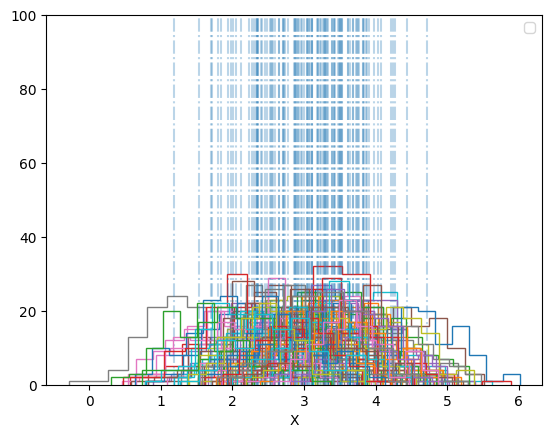

In [2]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 100
size_child = 100

# Hypothesis for parent gaussian 
## draws from parent  for mu child
true_parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(true_child_gaussian[i], fill=False, histtype='step')
    plt.vlines(np.mean(true_child_gaussian[i]), 0, size_child, linestyles='-.', alpha=0.3)
#plt.hist(true_parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian')
plt.xlabel("X")
plt.legend()
plt.ylim(0,size_child)

In [3]:
def log_hyperprior(params):
    parent_mean, parent_scale = params
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_likelihood(params):
    parent_mean, parent_scale = params
    samples_mu_child = true_child_gaussian # this has to be the true value whic has to be passed as in the observed value

    ##  \frac{1}{N_i} \sum_{j=1}^{N_i} \frac{1}{\sqrt{2\pi\sigma_p^2}} \exp(-\frac{(\mu_i^j-\mu_p)^2}{2\sigma_p^2})

    # likelihood = 1
    # for samples in samples_mu_child:
    #     this_L = np.mean((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples-parent_mean)**2 / (2 * parent_scale**2)))
    #     #mean = sum/size_child
    #     likelihood *= this_L
    
    ## These two lines represent what above loop does
    #mean = size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)
    #likelihood = np.prod(mean)
    
    return np.log(np.prod(np.mean((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [4]:
import emcee

pos = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(30, 2)
nwalkers, ndim = pos.shape

print(pos.shape)

#from multiprocessing import Pool

#with Pool() as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
)
sampler.run_mcmc(pos, 3000)

(30, 2)


/tmp/ipykernel_10903/3966127418.py:24: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(np.mean((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))


State([[3.09011441 0.49722514]
 [3.07681226 0.48817807]
 [3.01041893 0.48620484]
 [3.14819919 0.50842569]
 [2.9617041  0.46406905]
 [3.16329377 0.5800163 ]
 [3.00746558 0.51769068]
 [2.9960208  0.58739198]
 [2.97679756 0.528511  ]
 [3.05467899 0.5157796 ]
 [3.16825389 0.42000618]
 [3.13725815 0.60322842]
 [3.07824347 0.46253068]
 [3.03412464 0.50839099]
 [2.92814934 0.55672645]
 [3.03410533 0.58747162]
 [3.00041262 0.49479487]
 [3.11496062 0.40285466]
 [2.96842983 0.43671895]
 [3.16498703 0.49739336]
 [3.06251858 0.56071016]
 [2.981565   0.62721354]
 [3.00932173 0.58674496]
 [3.11361954 0.52314419]
 [3.02973173 0.62707969]
 [3.04054792 0.51448256]
 [3.05315227 0.55994454]
 [3.07471994 0.49920503]
 [3.15730004 0.40200976]
 [3.08644427 0.55572925]], log_prob=[-105.53206094 -105.42970486 -105.49176296 -106.4007193  -106.25426697
 -107.32694564 -105.57940272 -106.49839223 -105.97688186 -105.41520612
 -107.68330643 -107.26929543 -105.52833385 -105.39422624 -107.08304475
 -106.29328785 -105.

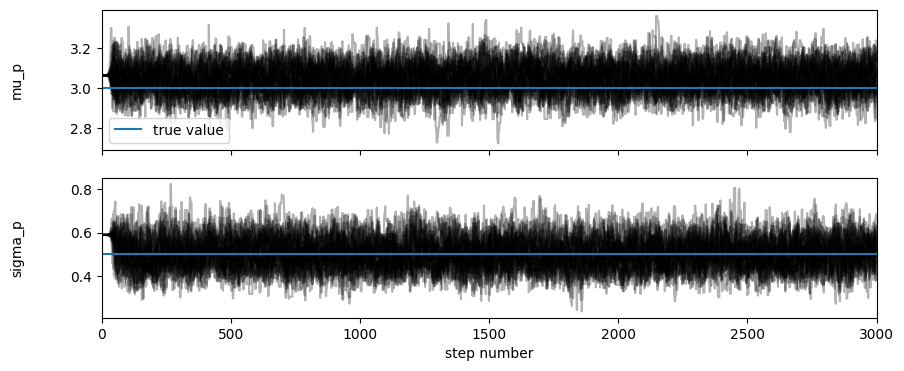

In [5]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [6]:
tau = sampler.get_autocorr_time()
print(tau)

[28.33058845 32.40875774]


In [7]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(5880, 2)


In [8]:
np.mean(flat_samples[:,0])

3.0468433867671894

In [9]:
np.mean(flat_samples[:,1])

0.5019924567240361

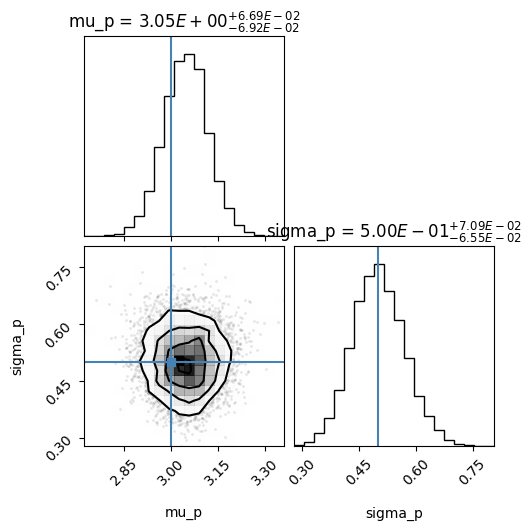

In [10]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)